# Sandbox

In [9]:
# data structures
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import string

# html
import requests 
import requests_cache
from bs4 import BeautifulSoup

# visualization
import matplotlib as mpl
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats

# text processing
import nltk
from textblob import TextBlob
from nltk import corpus
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re

# other
import time
import pprint as pp
import operator
import progressbar
import itertools
from time import sleep

from math import isnan

In [10]:
# setup
requests_cache.install_cache('aggie_cache')
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (15, 7)

# packages used by textblob
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")
# nltk.download("brown")
# nltk.download("wordnet")
# nltk.download("stopwords")

## Avg Response Time Per Tag


In [11]:
# filter: only interested in questions and answers where the questions have existing tags
Posts = pd.read_csv('../../../160-Stackoverflow-Data/300000_rows/Posts.csv', dtype={'LastEditorDisplayName': str})
Posts = Posts.loc[(Posts.PostTypeId == 1) | (Posts.PostTypeId == 2)]
Posts = Posts[(Posts.PostTypeId == 2) | ((Posts.PostTypeId == 1) & (len(Posts.Tags) > 0))]

# prepare data in better format
Posts.Tags = Posts.Tags.apply(lambda t: ' '.join(re.findall(r"<(\w+)>", str(t))))
Posts.CreationDate = pd.to_datetime(Posts.CreationDate, format="%Y-%m-%dT%H:%M:%S")
Posts.head(3)

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,48870881,1,NaN,48871194.0,2018-02-19 17:05:48.193,1,50.0,<p>I have a json file with data as below:</p>\...,2804169.0,2804169.0,NaN,2018-02-19T18:42:53.487,2018-02-19T18:53:19.357,NaN,NaN,PHP search array return all values,php arrays,2.0,0,NaN
1,48870882,1,NaN,48870993.0,2018-02-19 17:05:49.097,0,27.0,<p>I am currently working on a web application...,5128923.0,2598770.0,NaN,2018-02-19T17:13:33.920,2018-02-19T17:13:49.300,NaN,NaN,Creating a reactive user input tab,html,2.0,0,NaN
2,48870883,2,48869547.0,NaN,2018-02-19 17:05:50.073,1,NaN,<p>Try to add hint to the query:</p>\r\n\r\n<p...,8214734.0,8214734.0,NaN,2018-02-20T10:20:21.007,2018-02-20T10:20:21.007,NaN,NaN,NaN,,NaN,2,NaN


In [12]:
# if the parentID is empty, have it point to itself, this will simplify the query
def circulate_parentID(row):
    return row.Id if isnan(row.ParentID) else row.ParentID
        
Posts.ParentID = Posts.apply(circulate_parentID, axis=1)
Posts.ParentID = Posts.ParentID.astype('int64')
Posts.head(3)

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,48870881,1,48870881,48871194.0,2018-02-19 17:05:48.193,1,50.0,<p>I have a json file with data as below:</p>\...,2804169.0,2804169.0,NaN,2018-02-19T18:42:53.487,2018-02-19T18:53:19.357,NaN,NaN,PHP search array return all values,php arrays,2.0,0,NaN
1,48870882,1,48870882,48870993.0,2018-02-19 17:05:49.097,0,27.0,<p>I am currently working on a web application...,5128923.0,2598770.0,NaN,2018-02-19T17:13:33.920,2018-02-19T17:13:49.300,NaN,NaN,Creating a reactive user input tab,html,2.0,0,NaN
2,48870883,2,48869547,NaN,2018-02-19 17:05:50.073,1,NaN,<p>Try to add hint to the query:</p>\r\n\r\n<p...,8214734.0,8214734.0,NaN,2018-02-20T10:20:21.007,2018-02-20T10:20:21.007,NaN,NaN,NaN,,NaN,2,NaN


In [13]:
tag_response_times = defaultdict(list)
def map_response_times(df):
    # sort by creation date to get question and then answer
    df = df.sort_values(by=['CreationDate']).head(2)
    response_times = df['CreationDate'].values
    # convert the response time to minutes
    response_time = (response_times[1] - response_times[0]).astype('timedelta64[m]').astype(int)
    # map each tag with appropriate response time
    for tag in df['Tags'].values[0].split():
        tag_response_times[tag].append(response_time)
        
    
# query - group by the parent id then sort by creation date
#         the first data must be the question (posttypeid == 1)
#         and the second musst be the answer (if at all existent) (posttypeid == 2)
tag_list_by_time = Posts.groupby('ParentID')
bar = progressbar.ProgressBar()
for key, group in bar(tag_list_by_time):
    if group.shape[0] >= 2:
        map_response_times(group)

100% (176833 of 176833) |#################| Elapsed Time: 0:01:39 Time: 0:01:39


In [14]:
top_10_tags_response = sorted(tag_response_times.items(), key=lambda x: -len(x[1]))[0:10]
top_10_tags = [key for key, _ in top_10_tags_response]
top_10_tags

['javascript',
 'python',
 'java',
 'php',
 'android',
 'html',
 'jquery',
 'css',
 'sql',
 'r']

In [16]:
# now transpose to dataframe with proper labels in order to group (melt)
tag_labels, response_times = [], []
for tag, response in top_10_tags_response:
    tag_labels += [tag for _ in range(len(response))]
    response_times += response
top_10_tags_df = pd.DataFrame({'tag': tag_labels, 'response_time': response_times})
top_10_tags_df.head()

,response_time,tag
0,5,javascript
1,34,javascript
2,40,javascript
3,6,javascript
4,21,javascript


Text(0.5,1,'Average Response Time for the 10 Most Popular Tags in Minutes')

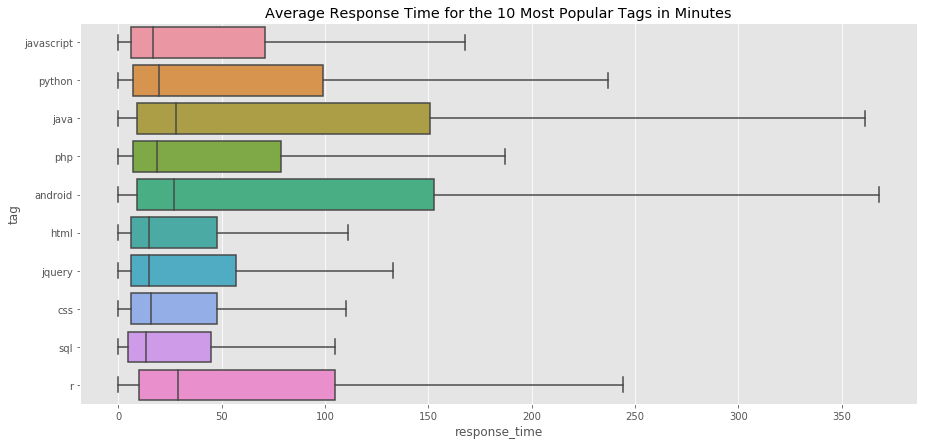

In [17]:
sns.boxplot(x="response_time", y="tag", data=top_10_tags_df, showfliers=False)
plt.title('Average Response Time for the 10 Most Popular Tags in Minutes')

## How many questions are left unanswered?

In [18]:
Posts = pd.read_csv('../../../160-Stackoverflow-Data/300000_rows/Posts.csv', dtype={'LastEditorDisplayName': str})
Posts.head()

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,48870881,1,NaN,48871194.0,2018-02-19T17:05:48.193,1,50.0,<p>I have a json file with data as below:</p>\...,2804169.0,2804169.0,NaN,2018-02-19T18:42:53.487,2018-02-19T18:53:19.357,NaN,NaN,PHP search array return all values,<php><arrays>,2.0,0,NaN
1,48870882,1,NaN,48870993.0,2018-02-19T17:05:49.097,0,27.0,<p>I am currently working on a web application...,5128923.0,2598770.0,NaN,2018-02-19T17:13:33.920,2018-02-19T17:13:49.300,NaN,NaN,Creating a reactive user input tab,<c#><html><asp.net><.net><visual-studio>,2.0,0,NaN
2,48870883,2,48869547.0,NaN,2018-02-19T17:05:50.073,1,NaN,<p>Try to add hint to the query:</p>\r\n\r\n<p...,8214734.0,8214734.0,NaN,2018-02-20T10:20:21.007,2018-02-20T10:20:21.007,NaN,NaN,NaN,NaN,NaN,2,NaN
3,48870884,2,3865445.0,NaN,2018-02-19T17:05:50.273,0,NaN,In support of Sean's post:\r\n\r\n<p>The place...,2055283.0,NaN,NaN,NaN,2018-02-19T17:05:50.273,NaN,NaN,NaN,NaN,NaN,0,NaN
4,48870885,2,48870539.0,NaN,2018-02-19T17:05:51.300,0,NaN,<p>I discovered the convention (couldn't find ...,1052870.0,NaN,NaN,NaN,2018-02-19T17:05:51.300,NaN,NaN,NaN,NaN,NaN,1,NaN


In [19]:
n_questions = len(Posts.loc[Posts.PostTypeId == 1])
n_unanswered = len(Posts.loc[(Posts.PostTypeId == 1) & (Posts.AcceptedAnswerId.isnull())])
# print(n_questions, n_unanswered)
print(f'Approximately {n_unanswered/n_questions*100}% of questions remain with nonaccepted answers.')

Approximately 72.12015164771071% of questions remain with nonaccepted answers.


In [20]:
# in what context does only 28% of questions get answered?
Posts.CreationDate = pd.to_datetime(Posts.CreationDate, format="%Y-%m-%dT%H:%M:%S")
Posts_sorted = Posts.sort_values(by=['CreationDate'])
earliest_date = Posts_sorted.iloc[0]['CreationDate']
latest_date = Posts_sorted.iloc[-1]['CreationDate']

print(f'In the context of our sample, the earliest post was {earliest_date} and the latest post was {latest_date}.')
print('Which suggests that within a 3 month timespan only a quarter of posted questions get answered.')

In the context of our sample, the earliest post was 2018-01-26 19:05:05.213000 and the latest post was 2018-03-11 04:55:43.843000.
Which suggests that within a 3 month timespan only a quarter of posted questions get answered.


In [25]:
# how many questions get absolutely no answers?
# there should only ever be a unique post id per question
n_questions = len(Posts.loc[Posts.PostTypeId == 1])

# to obtain the number of answers, we count the number of unique parent ids,
n_answers = len(set(Posts.loc[(Posts.PostTypeId == 2)].ParentID.values))
print(f'Approximately {(1 - (n_answers/n_questions))*100}% of questions remain unanswered.')

Approximately 22.382279734413046% of questions remain unanswered.


# Ignore


In [23]:
# CountVectorizer followed by TfidfTransformer
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', max_df=.9)
X = vectorizer.fit_transform(user_qac['asks_title'].values)

# view feature matrix as sample dataframe
# col = [feature for feature in vectorizer.get_feature_names()]
# temp = pd.DataFrame(X.todense(), columns=col)
# temp.head()

print(X.shape) # prev: (70012, 20153)

NameError: name 'user_qac' is not defined

In [ ]:
# full matrix computation (does not fit in memory...)
# tf_idf_m = (X * X.T).A

# compute the similiarity between two users based on transformed bag of words model
user_sim = defaultdict(list)
bar = progressbar.ProgressBar()
temp_count = 0
for i in range(range(X.shape[0])):
    for j in range(range(X.shape[0])):
        user_sim['user_id1'].append(user_qac.iloc[i]['userid'])
        user_sim['user_id2'].append(user_qac.iloc[j]['userid'])
        similiarity = (X[i] * X[j].T).A[0][0]
        user_sim['ask_title_similiarity'].append(similiarity)
#     temp_count += 1
#     if temp_count > 20:
#         break
        
tmp = pd.DataFrame(user_sim)

In [ ]:
b = pd.read_csv('../../160-Stackoverflow-Data/300000_rows/user_communication.csv')

In [ ]:
# see: https://api.stackexchange.com/docs/synonyms-by-tags#order=desc&sort=creation&tags=php&filter=default&site=stackoverflow&run=true
tag = 'javascript'
url = 'https://api.stackexchange.com/2.2/tags/javascript/synonyms?order=desc&sort=creation&site=stackoverflow'
BASE_URL = f'https://api.stackexchange.com/2.2/tags/{tag}/synonyms?'
params = {'order': 'desc',
          'sort': 'creation',
          'site': 'stackoverflow'}

response = requests.get(BASE_URL, params = params).json()
response

# import requests
# import pandas as pd
# import progressbar

# # 30 requests a second 

# # if __name__ == "__main__":
# with open('all_unique_tags.txt', 'r') as file:
#     all_tags = [line.rstrip('\n') for line in file.readlines()]
#     master_tags = []
#     bar = progressbar.ProgressBar()
#     count = 0
#     for tag in bar(all_tags):
#         min_syn = find_minimum_synonym(tag, all_tags)
#         synoymns.append(min_syn if min_syn else tag)
#     pd.DataFrame({'tag': all_tags, 'master_tag': master_tags}).to_csv('master_tags.csv')
